# Measuring the size of Quantum Dots through their Emission Spectrum
## $-$ Practice A
----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs( "./Output_Figures/", exist_ok=True)

# Constants

In [2]:
gamma = 0.001 # or 0.1 # (eV)
num_R_pts = 1000

# constants
e=1.602176634e-19
h=6.6261e-34
c=2.9979e8
conv=h*c/e*1e9 # E=conv/lamb
m=9.1093837e-31
hbar=h/2/np.pi
vac_per=8.854187e-12
# Exciton params #######
E_gap=1.8
eps=8.3
me=0.13
mh=0.45
Vo = 4 #eV


hbarSqPiSq2mu=hbar**2*np.pi**2*10**18*(1/me+1/mh)/(2*m*e)
factor_eh = -1.786*e*10**9/(4*np.pi*vac_per*eps)

hbarSqPiSq2m = hbar**2*np.pi**2*10**18/(2*m*e)
sqrtVomhbarSq2=np.sqrt(2*Vo*e*m)/hbar/10**9
factor_eh_fin = e*10**9/(4*np.pi*eps*vac_per)

# Data Treatment

In [3]:
path="./Raw_Emission_Spectra/"
names = ["rojo_1412151E1.TXT", "Naranja_1412151E1.TXT",
         "liquido_1412151E1.TXT",
         "Verde_flojito_Amarillo_1412151E1.TXT", 
        "Verde_1412151E1.TXT", 
         "azul_placido_1412151E1.TXT",
        ]
files=[]
for j in range(len(names)):
    files.append(path+names[j])

>> rojo_1412151E1.TXT ##################################


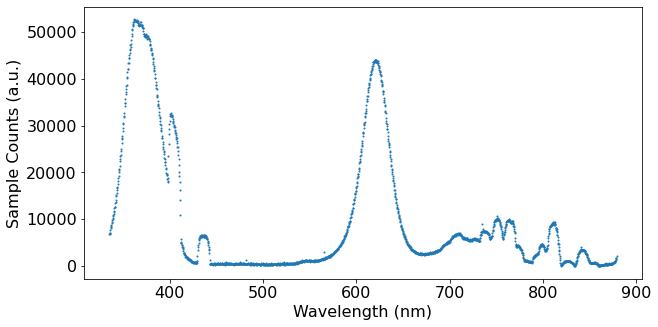

>> Naranja_1412151E1.TXT ##################################


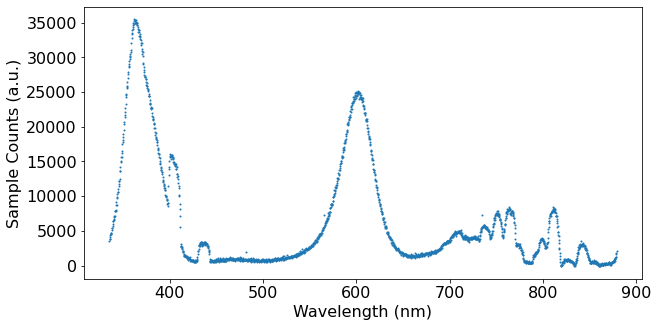

>> liquido_1412151E1.TXT ##################################


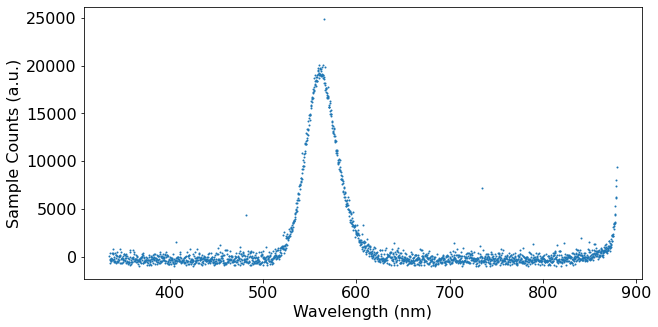

>> Verde_flojito_Amarillo_1412151E1.TXT ##################################


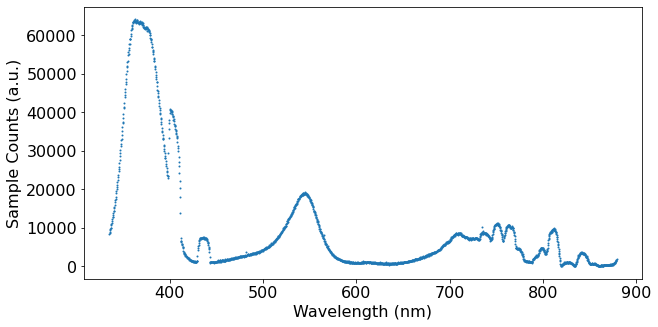

>> Verde_1412151E1.TXT ##################################


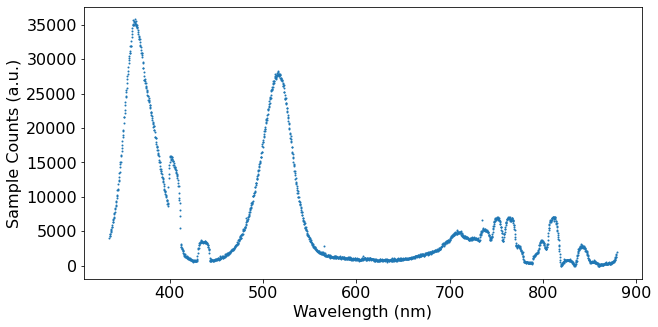

>> azul_placido_1412151E1.TXT ##################################


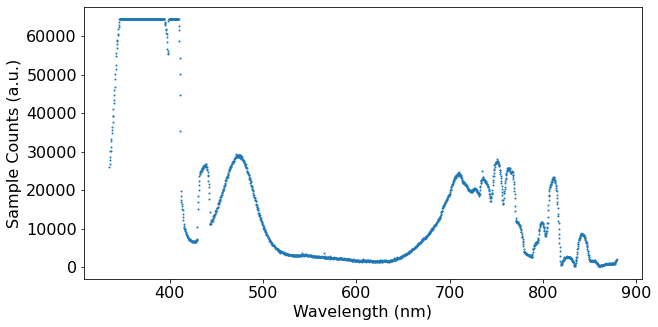

In [4]:
plt.rcParams.update({'font.size': 16})

datas=[]
for i in range(len(files)):
    print(f">> {names[i]} ##################################")
    datas.append( pd.read_csv(files[i], delimiter=";", decimal=",") )# import data separated with dot commas as pandas dataframe "array"
    datas[i].columns=datas[i].columns.str.replace(' ','') # spaces out in column names

    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.plot(datas[i]['Wave'], datas[i]['Sample'], 'o', markersize=1)

    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Sample Counts (a.u.)")
    plt.savefig(f"./Output_Figures/Sample_{i}_RAW.png")
    plt.show()
    '''
    plt.plot(datas[i]['Wave'], datas[i]['Dark'])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Dark Counts (a.u.)")
    plt.show()
    '''

>> rojo_1412151E1.TXT ##################################


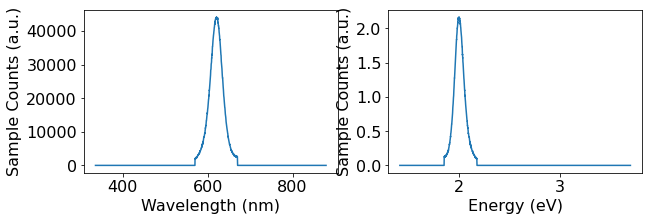

>> Naranja_1412151E1.TXT ##################################


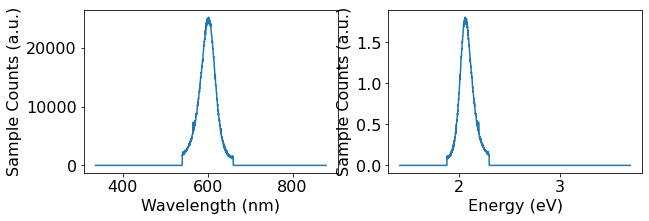

>> liquido_1412151E1.TXT ##################################


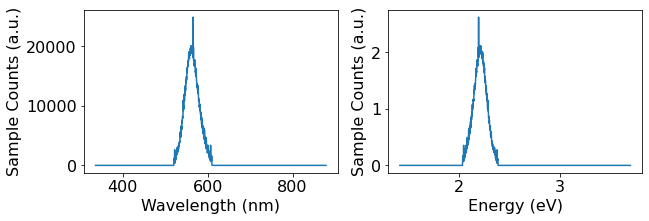

>> Verde_flojito_Amarillo_1412151E1.TXT ##################################


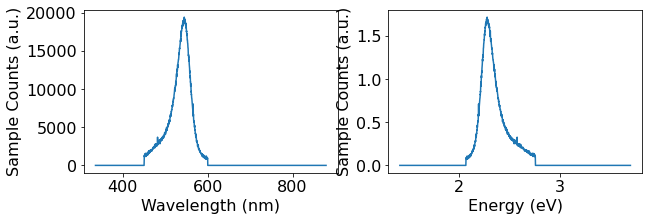

>> Verde_1412151E1.TXT ##################################


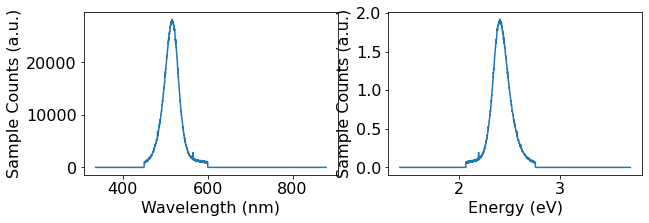

>> azul_placido_1412151E1.TXT ##################################


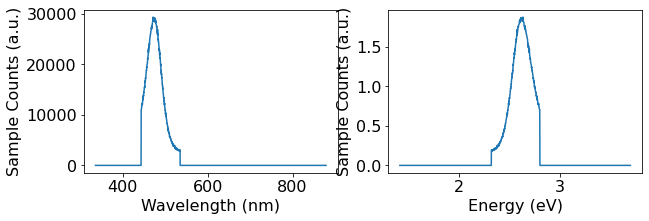

In [5]:
filtered_datas=[]
Ejss=[]
Ijss=[]
# Choose windows!
#windows = [[570, 670],[550,650],[500,650],[460,600],[460,590],[450,520]]
windows = [[570,670],[540,660],[520,610],[450,600],[450,600],[443,535]]

for i in range(len(windows)):
    print(f">> {names[i]} ##################################")
    filtered_datas.append(datas[i].to_numpy()[:,:2].copy())
    filtered_datas[i][filtered_datas[i][:,0]<windows[i][0], 1]=0
    filtered_datas[i][filtered_datas[i][:,0]>windows[i][1], 1]=0
    
    Ejss.append( conv/filtered_datas[i][:,0] )
    Ijss.append( filtered_datas[i][:,1]/(np.sum(filtered_datas[i][:,1])*abs((Ejss[-1][1]-Ejss[-1][0]))) )

    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].plot(filtered_datas[i][:,0], filtered_datas[i][:,1])
    axs[0].set_xlabel("Wavelength (nm)")
    axs[0].set_ylabel("Sample Counts (a.u.)")
    
    axs[1].plot(Ejss[-1], Ijss[-1])
    axs[1].set_xlabel("Energy (eV)")
    axs[1].set_ylabel("Sample Counts (a.u.)")
    plt.show()



# General Algorithm

In [6]:
import scipy
from scipy import optimize

In [7]:
def gaussian(x, mean, std):
    return (1/(std*np.sqrt(2*np.pi)))*np.exp(-(x-mean)**2/(2*std**2))

def rho_F( R, E, E_exc,    M, R0, sigmaR):
    return gaussian(R, R0, sigmaR)*gaussian(E, E_exc(R), gamma)

def I(Ejs, E_exc, M,R0,sigmaR,N): # que se calcule el vector entero de una
    R_ks = np.linspace(max(0.01,R0-3*sigmaR), R0+3*sigmaR, num_R_pts)
    #R_ks = np.linspace(max(0.0001, R0-3*sigmaR), R0+3*sigmaR, num_R_pts)
    #print(M,R0,sigmaR,N)
    rho_F_j_k = rho_F(R_ks[:, np.newaxis], Ejs[np.newaxis,:], E_exc, M,R0,sigmaR) # [N_Ej, N_Rj]
    # integrate
    return N+M*np.sum(rho_F_j_k, axis=0)*(R_ks[1]-R_ks[0]) # [N_Ej]
def Cost(Ijs, Ejs, E_exc, M, R0, sigmaR, N): # only where the data is experimental -not where zero padding!-
    return np.mean(((I(Ejs, E_exc, M, R0, sigmaR, N)-Ijs)**2)[np.where(Ijs)])

In [8]:
print(hbarSqPiSq2mu, factor_eh, hbarSqPiSq2m, sqrtVomhbarSq2, factor_eh_fin )

3.728195886959132 -0.309852640786958 0.37603355066742966 10.24628827966727 0.17348972048541877


## Infinite Potential

In [9]:
def E_exc_inf(R):
    return E_gap+hbarSqPiSq2mu/R**2+factor_eh/R

In [10]:
results={}

In [11]:
options={'maxiter':2000, 'maxfev': 2000,
        'xatol':0, 'fatol':0,}
dont_do=[]
initial_guesses=[[1, 2.2, 0.5, 0.1], [1, 2.2, 0.5, 0.1], [1, 2.2, 0.5, 0.1],
                [1, 2.2, 0.5, 0.1], [1, 2.2, 0.5, 0.1], [1, 2.2, 0.5, 0.2]]

for i in range(len(filtered_datas)):
    if i in dont_do:
        continue
        
    C = lambda xs : Cost(Ijss[i], Ejss[i], E_exc_inf, xs[0],xs[1],xs[2],xs[3])
    # M,R0,sigmaR,N
    results[f'{i}'] = scipy.optimize.minimize(C, initial_guesses[i], method='Nelder-Mead',
                    bounds=((0,1e6),(1, 100), (0, 20), (0,20)),
                    #constraints=(), 
                    tol=None, options=options).x     
    print(f"Done {i}-th sample!")

Done 0-th sample!
Done 1-th sample!
Done 2-th sample!
Done 3-th sample!
Done 4-th sample!
Done 5-th sample!


>> rojo_1412151E1.TXT############################################
Best fit R0=3.59nm sigmaR=0.335nm         M=0.221 N=0.162
E_exc_inf(R0)=2.0eV    E_exc(R0-sigma)=1.96eV    E_exc(R0+sigma)=2.06eV


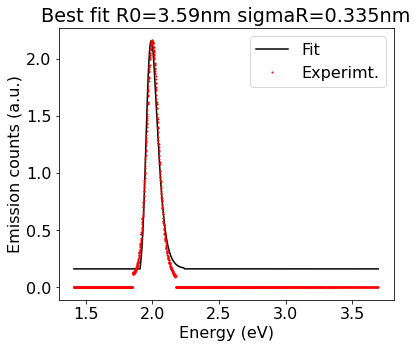

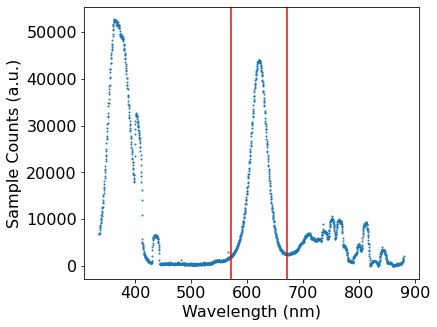

>> Naranja_1412151E1.TXT############################################
Best fit R0=3.17nm sigmaR=0.299nm         M=0.234 N=0.146
E_exc_inf(R0)=2.07eV    E_exc(R0-sigma)=2.02eV    E_exc(R0+sigma)=2.14eV


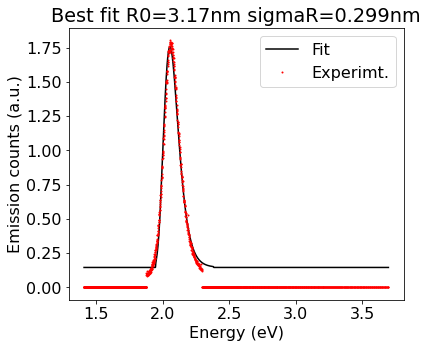

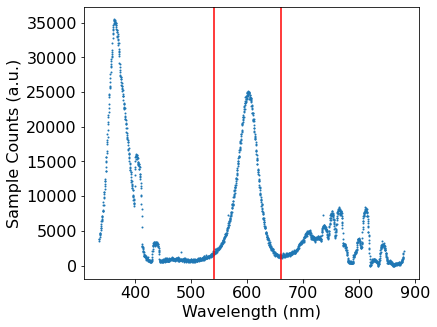

>> liquido_1412151E1.TXT############################################
Best fit R0=2.66nm sigmaR=0.171nm         M=0.277 N=0.18
E_exc_inf(R0)=2.21eV    E_exc(R0-sigma)=2.16eV    E_exc(R0+sigma)=2.28eV


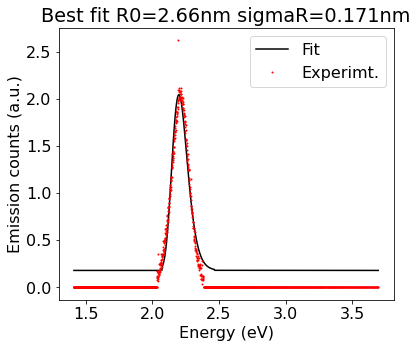

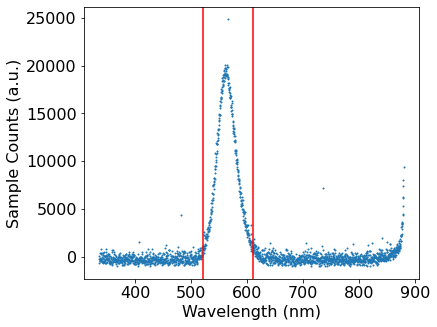

>> Verde_flojito_Amarillo_1412151E1.TXT############################################
Best fit R0=2.44nm sigmaR=0.159nm         M=0.259 N=0.172
E_exc_inf(R0)=2.3eV    E_exc(R0-sigma)=2.23eV    E_exc(R0+sigma)=2.38eV


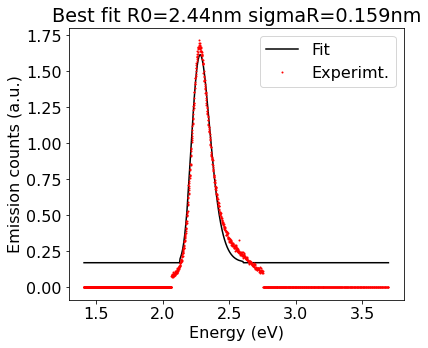

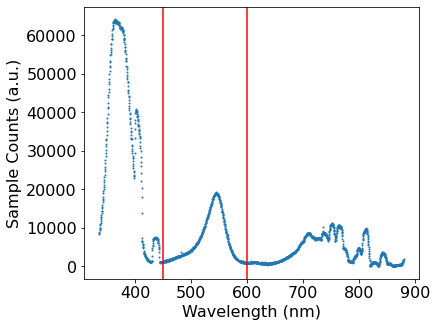

>> Verde_1412151E1.TXT############################################
Best fit R0=2.22nm sigmaR=0.127nm         M=0.342 N=0.0972
E_exc_inf(R0)=2.42eV    E_exc(R0-sigma)=2.34eV    E_exc(R0+sigma)=2.5eV


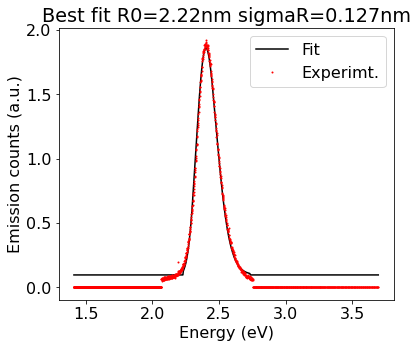

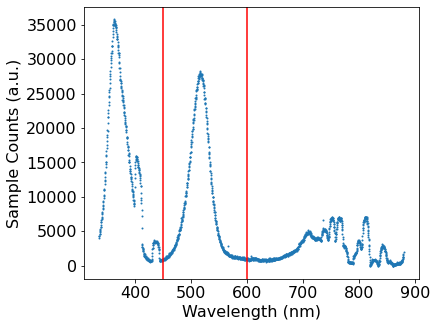

>> azul_placido_1412151E1.TXT############################################
Best fit R0=1.94nm sigmaR=0.107nm         M=0.4 N=0.23
E_exc_inf(R0)=2.63eV    E_exc(R0-sigma)=2.54eV    E_exc(R0+sigma)=2.74eV


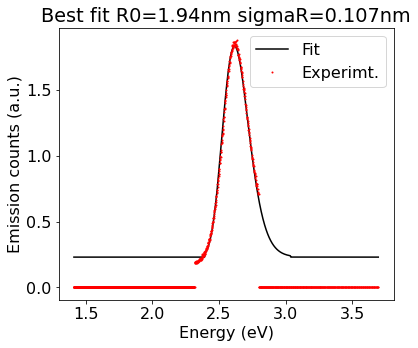

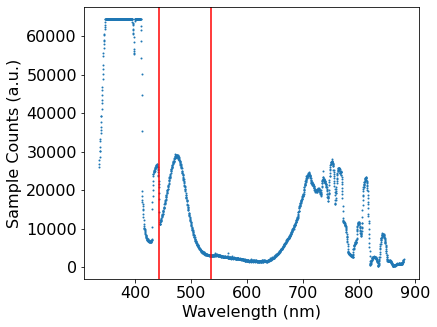

In [12]:
for k in results.keys():
    i=int(k)
    print(f">> {names[i]}############################################")
    M,R0,sigmaR,N = results[k]
    best_fit = I(Ejss[i], E_exc_inf, M,R0,sigmaR,N)
    print(f"Best fit R0={R0:.3}nm sigmaR={sigmaR:.3}nm         M={M:.3} N={N:.3}")
    print(f"E_exc_inf(R0)={E_exc_inf(R0):.3}eV    E_exc(R0-sigma)={E_exc_inf(R0+sigmaR):.3}eV    E_exc(R0+sigma)={E_exc_inf(R0-sigmaR):.3}eV")
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.plot(Ejss[i], best_fit, color='black', label=f"Fit")
    ax.set_title(f"Best fit R0={R0:.3}nm sigmaR={sigmaR:.3}nm")
    ax.plot(Ejss[i], Ijss[i], 'or', markersize=1, label="Experimt.")
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Emission counts (a.u.)")
    ax.legend()
    plt.savefig(f"./Output_Figures/Sample_{i}_fitted_infinite.png")
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.plot(datas[i]['Wave'], datas[i]['Sample'], 'o', markersize=1)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Sample Counts (a.u.)")
    plt.axvline(windows[i][0],ymin=0,ymax=1, color="r")
    plt.axvline(windows[i][1],ymin=0,ymax=1, color="r")
    plt.savefig(f"./Output_Figures/Sample_{i}_RAW_marked.png")
    plt.show()

## Finite Potential 

In [10]:
from scipy.special import spherical_jn, sici

# AQUÍ LAS FUNCIONES BESSEL Y SCI DEFINIDAS YA!
j1 = lambda z: spherical_jn(n=1, z=z, derivative=False)
Si = lambda x: sici(x)[0] # solo nos interesa si (el otro es la integral del coseno)

In [11]:
#Funciones que utilizamos:
def fi(v):
    return 1/(1+1/v+(np.pi/2-1)**2/(v*(v-1)))

def E_exc_fin(R):
    ve=sqrtVomhbarSq2*np.sqrt(me)*R
    vh=sqrtVomhbarSq2*np.sqrt(mh)*R
    fve=fi(ve)
    fvh=fi(vh)
    E_eh = -(factor_eh_fin/R)*((2*np.pi**(-5/2)*(fvh**(-1))*(fve**(-3/2)))/(j1(np.pi*fve)*j1(np.pi*fvh)))**2*(-1/4*Si(2*np.pi*fve)-1/8*Si(2*np.pi*(fvh-fve))+1/8*Si(2*np.pi*(fvh+fve))+fve/(2*fvh)*(np.pi*fvh-np.cos(np.pi*fvh)*np.sin(np.pi*fvh)))
    return E_gap+hbarSqPiSq2m/(me*(R**2))*(fve**2)+hbarSqPiSq2m/(mh*(R**2))*(fvh**2) + E_eh

In [16]:
resultsf={}

In [19]:
options={'maxiter':2000, 'maxfev': 2000,
        'xatol':0, 'fatol':0,}
dont_do=[0,1,2,3,4]
initial_guesses=[[1, 2.2, 0.5, 0.01], [1, 2.2, 0.5, 0.01], [1, 2.2, 0.5, 0.01],
                [1, 2.2, 0.5, 0.1], [1, 2.2, 0.5, 0.1], [1, 2.2, 0.5, 0.12]]

for i in range(len(filtered_datas)):
    if i in dont_do:
        continue
        
    C = lambda xs : Cost(Ijss[i], Ejss[i], E_exc_fin, xs[0],xs[1],xs[2],xs[3])
    # M,R0,sigmaR,N
    resultsf[f'{i}'] = scipy.optimize.minimize(C, initial_guesses[i], method='Nelder-Mead',
                    bounds=((0,1e6),(1, 100), (0, 20), (0,20)),
                    #constraints=(), 
                    tol=None, options=options).x  
    print(f"Done {i}-th sample!")

/home/melanie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


Done 5-th sample!


>> rojo_1412151E1.TXT############################################
Best fit R0=3.39nm sigmaR=0.344nm         M=0.221 N=0.163
E_exc_fin(R0)=2.0eV    E_exc(R0-sigma)=1.96eV    E_exc(R0+sigma)=2.06eV


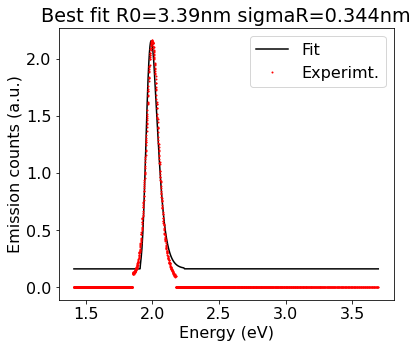

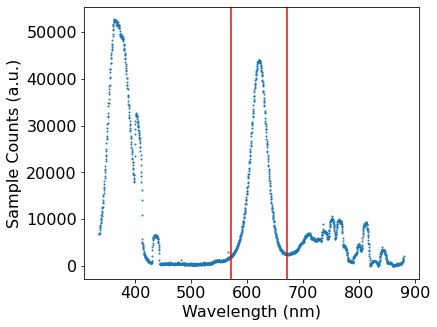

>> Naranja_1412151E1.TXT############################################
Best fit R0=2.94nm sigmaR=0.351nm         M=0.287 N=0.0
E_exc_fin(R0)=2.08eV    E_exc(R0-sigma)=2.02eV    E_exc(R0+sigma)=2.16eV


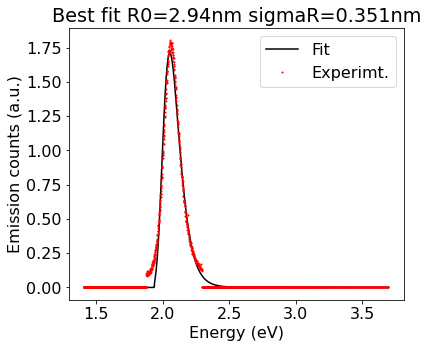

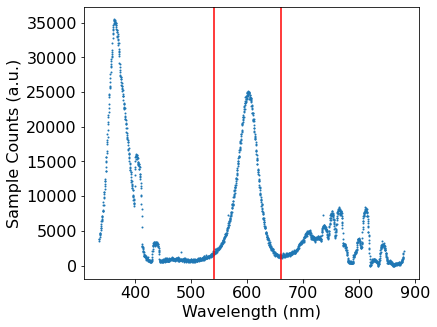

>> liquido_1412151E1.TXT############################################
Best fit R0=2.44nm sigmaR=0.176nm         M=0.277 N=0.18
E_exc_fin(R0)=2.21eV    E_exc(R0-sigma)=2.16eV    E_exc(R0+sigma)=2.28eV


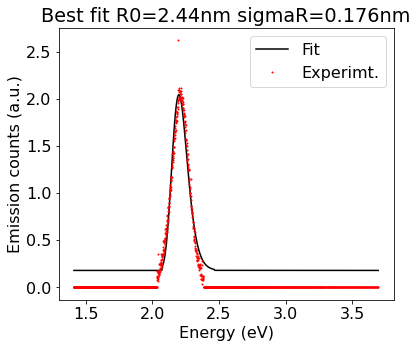

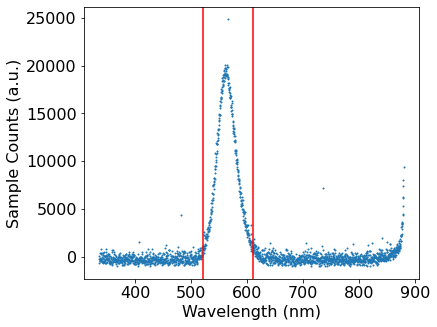

>> Verde_flojito_Amarillo_1412151E1.TXT############################################
Best fit R0=2.22nm sigmaR=0.164nm         M=0.259 N=0.172
E_exc_fin(R0)=2.3eV    E_exc(R0-sigma)=2.23eV    E_exc(R0+sigma)=2.38eV


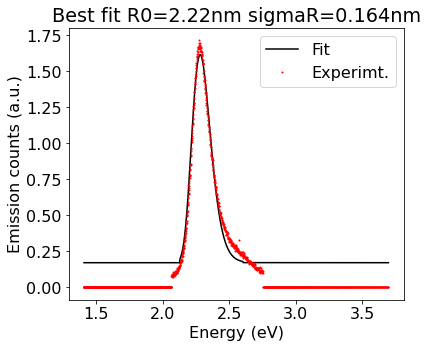

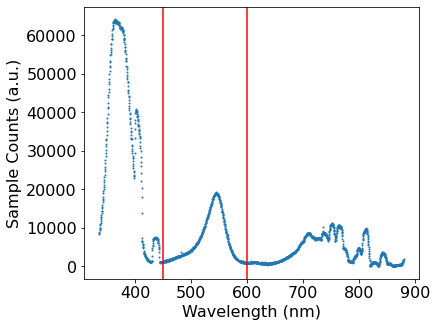

>> Verde_1412151E1.TXT############################################
Best fit R0=1.99nm sigmaR=0.131nm         M=0.342 N=0.0972
E_exc_fin(R0)=2.42eV    E_exc(R0-sigma)=2.34eV    E_exc(R0+sigma)=2.5eV


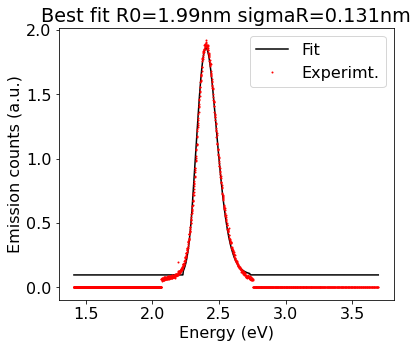

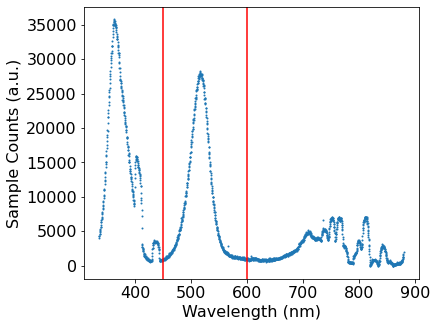

>> azul_placido_1412151E1.TXT############################################
Best fit R0=1.69nm sigmaR=0.111nm         M=0.4 N=0.23
E_exc_fin(R0)=2.63eV    E_exc(R0-sigma)=2.54eV    E_exc(R0+sigma)=2.74eV


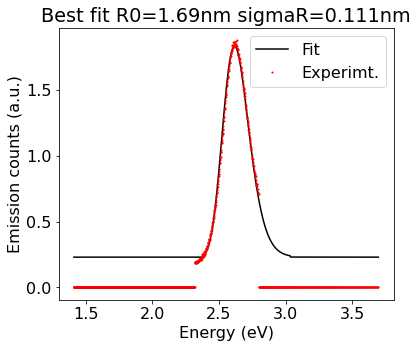

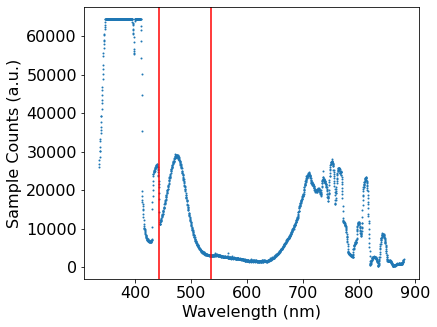

In [20]:
for k in resultsf.keys():
    i=int(k)
    print(f">> {names[i]}############################################")
    M,R0,sigmaR,N = resultsf[k]
    best_fit = I(Ejss[i], E_exc_fin, M,R0,sigmaR,N)
    print(f"Best fit R0={R0:.3}nm sigmaR={sigmaR:.3}nm         M={M:.3} N={N:.3}")
    print(f"E_exc_fin(R0)={E_exc_fin(R0):.3}eV    E_exc(R0-sigma)={E_exc_fin(R0+sigmaR):.3}eV    E_exc(R0+sigma)={E_exc_fin(R0-sigmaR):.3}eV")
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.plot(Ejss[i], best_fit, color='black', label=f"Fit")
    ax.set_title(f"Best fit R0={R0:.3}nm sigmaR={sigmaR:.3}nm")
    ax.plot(Ejss[i], Ijss[i], 'or', markersize=1, label="Experimt.")
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Emission counts (a.u.)")
    ax.legend()
    plt.savefig(f"./Output_Figures/Sample_{i}_fitted_finite.png")
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    ax.plot(datas[i]['Wave'], datas[i]['Sample'], 'o', markersize=1)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Sample Counts (a.u.)")
    plt.axvline(windows[i][0],ymin=0,ymax=1, color="r")
    plt.axvline(windows[i][1],ymin=0,ymax=1, color="r")
    plt.savefig(f"./Output_Figures/Sample_{i}_RAW_marked.png")
    plt.show()

ve 7.38870355510521e+30
fve 1.0
Egap+CM FINITE 2.7320489717397827
Egap+CM INFINITE 2.732048971739783
-4/pi=-1.2732395447351628 fact lim=1.273239544735162
Lim -1.786 bide ->-1.7860731681516873
FINITE Factor eh 1.7860731681516864
INIFINITE Factor eh 1.7860000000000005
E_eh FINITE -0.15493266735457123
E_eh INIFINITE 0.154926320393479


NameError: name 'E_exc_inf' is not defined

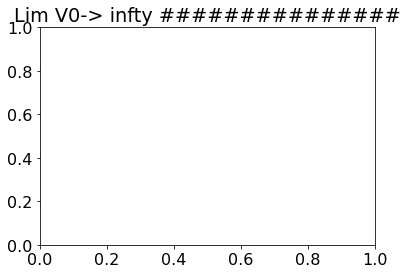

In [11]:
R=2
sR = 0.2
R_s = np.linspace(max(0.01,R-3*sR), R+3*sR, num_R_pts)

plt.title("Lim V0-> infty ###############")

Vo=4e60
sqrtVomhbarSq2=np.sqrt(2*Vo*e*m/hbar**2)/10**9

ve=sqrtVomhbarSq2*np.sqrt(me)*R
vh=sqrtVomhbarSq2*np.sqrt(mh)*R

fve=fi(ve)
fvh=fi(vh)

print(f"ve {ve}")
print(f"fve {fve}")
print(f"Egap+CM FINITE {E_gap+hbarSqPiSq2m/(me*(R**2))*(fve**2)+hbarSqPiSq2m/(mh*(R**2))*(fvh**2)}")
print(f"Egap+CM INFINITE {E_gap+hbarSqPiSq2mu/R**2}")
print(f"-4/pi={-4/np.pi} fact lim={((2*np.pi**(-5/2)*(fvh**(-1))*(fve**(-3/2)))/(j1(np.pi*fve)*j1(np.pi*fvh)))**2}")
print(f"Lim -1.786 bide ->{-4/np.pi*((-1/4*Si(2*np.pi*fve))-1/8*Si(2*np.pi*(fvh-fve))+1/8*Si(2*np.pi*(fvh+fve))+fve/(2*fvh)*(np.pi*fvh-np.cos(np.pi*fvh)*np.sin(np.pi*fvh)))}")
print(f"FINITE Factor eh {((2*np.pi**(-5/2)*(fvh**(-1))*(fve**(-3/2)))/(j1(np.pi*fve)*j1(np.pi*fvh)))**2*(-1/4*Si(2*np.pi*fve)-1/8*Si(2*np.pi*(fvh-fve))+1/8*Si(2*np.pi*(fvh+fve))+fve/(2*fvh)*(np.pi*fvh-np.cos(np.pi*fvh)*np.sin(np.pi*fvh)))}")
print(f"INIFINITE Factor eh {-factor_eh/factor_eh_fin}")
print(f"E_eh FINITE { -(factor_eh_fin/R)*((2*np.pi**(-5/2)*(fvh**(-1))*(fve**(-3/2)))/(j1(np.pi*fve)*j1(np.pi*fvh)))**2*(-1/4*Si(2*np.pi*fve)-1/8*Si(2*np.pi*(fvh-fve))+1/8*Si(2*np.pi*(fvh+fve))+fve/(2*fvh)*(np.pi*fvh-np.cos(np.pi*fvh)*np.sin(np.pi*fvh)))}")
print(f"E_eh INIFINITE {-factor_eh/R}")
Einf = E_exc_inf(R_s)
Efin = E_exc_fin(R_s)

plt.plot(R_s, Einf, label="Infintie Potential")
plt.plot(R_s, Efin, label="Finite Potential")
plt.xlabel("Radious (nm)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.title(f"V0={Vo}eV ###############")

plt.show()


Einf = E_exc_inf(R_s)
Efin = E_exc_fin(R_s)



Vo=4
sqrtVomhbarSq2=np.sqrt(2*Vo*e*m/hbar**2)/10**9

ve=sqrtVomhbarSq2*np.sqrt(me)*R
vh=sqrtVomhbarSq2*np.sqrt(mh)*R

fve=fi(ve)
fvh=fi(vh)
print(f"E_eh FINITE { -(factor_eh_fin/R)*((2*np.pi**(-5/2)*(fvh**(-1))*(fve**(-3/2)))/(j1(np.pi*fve)*j1(np.pi*fvh)))**2*(-1/4*Si(2*np.pi*fve)-1/8*Si(2*np.pi*(fvh-fve))+1/8*Si(2*np.pi*(fvh+fve))+fve/(2*fvh)*(np.pi*fvh-np.cos(np.pi*fvh)*np.sin(np.pi*fvh)))}")
print(f"E_eh INIFINITE {-factor_eh/R}")

Einf = E_exc_inf(R_s)
Efin = E_exc_fin(R_s)
plt.plot(R_s, Einf, label="Infintie Potential")
plt.plot(R_s, Efin, label="Finite Potential")
plt.xlabel("Radious (nm)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.title(f"V0={Vo}eV ###############")

plt.show()

# The 3$w$ Method
## $-$ Practice B
----

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# $SiO_2$

In [2]:
# 30 microns
# log(2w)
x1 = np.array([2.89037175789616,
3.58351893845611,
4.30406509320417,
5.02388052084628,
5.61320109642496,
6.31720078717869,
7.21670948670946,
7.58885012101791,
7.56841025909183,
2.99473177322041,
6.94126742151459
])
#dT/P
y1 = np.array([
8.82302397171446,
8.58213053610386,
8.11028160820966,
7.82722235723184,
7.29463212212356,
6.8758172322513,
6.27485783536455,
6.07771418565288,
5.85217923813737,
8.66934543627989,
6.31355847049037
])
x1 = sm.add_constant(x1, prepend=False)

model1 = sm.OLS(y1,x1)
result1 = model1.fit()
result1.summary()

/home/melanie/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     688.2
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           8.21e-10
Time:                        20:56:47   Log-Likelihood:                 7.5895
No. Observations:                  11   AIC:                            -11.18
Df Residuals:                       9   BIC:                            -10.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6151      0.023    -26.233      0.000      -0.668      -0.562
const         10.6941      0.134     79.667      0.000      10.390      10.998
==============================================================================
Omnibus:                        0.129   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.338
Skew:                          -0.096   Prob(JB):                        0.844
Kurtosis:                       2.163   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
# 50 microns
# log(2w)
x2 = np.array([
    3.09104245335832,
3.8286413964891,
4.30406509320417,
5.02388052084628,
5.61320109642496,
6.31720078717869,
7.06648403483777,
6.77083529441654,
7.57666099516905

])
#dT/P
y2 = np.array([
6.42684247898271,
5.91026539069161,
5.66208442284285,
5.35376494522078,
5.09865127213067,
4.66593442923722,
4.02483072354925,
4.36005537247241,
3.88124611442666

])

x2 = sm.add_constant(x2, prepend=False)
model2 = sm.OLS(y2,x2)
result2 = model2.fit()
result2.summary()

/home/melanie/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     828.5
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           1.57e-08
Time:                        20:56:49   Log-Likelihood:                 10.466
No. Observations:                   9   AIC:                            -16.93
Df Residuals:                       7   BIC:                            -16.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5617      0.020    -28.784      0.000      -0.608      -0.516
const          8.1376      0.111     73.140      0.000       7.875       8.401
==============================================================================
Omnibus:                        0.509   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.437
Skew:                          -0.412   Prob(JB):                        0.804
Kurtosis:                       2.301   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
from scipy.stats import norm
l=0.002
b1=15e-6
b2=25e-6
h=400e-9
conf = 0.9

S1=result1.params[0]
S2=result2.params[0]
sigmaS1=result1.bse[0]
sigmaS2=result2.bse[0]
print(f"S1={S1:.5} sigmaS1={sigmaS1:.5}")
print(f"S2={S2:.5} sigmaS2={sigmaS2:.5}")

ksubs1 = -1/(2*np.pi*l*S1)
ksubs2 = -1/(2*np.pi*l*S2)
sigmaks1=sigmaS1/(4*np.pi*l*S1**2)
sigmaks2=sigmaS2/(4*np.pi*l*S2**2)
print(f"ksubs1={ksubs1:.5} sigmaks1={sigmaks1:.5}")
print(f"ksubs2={ksubs2:.5} sigmaks2={sigmaks2:.5}\n")

ksubs = (ksubs1+ksubs2)/2
sigmaks = 0.5*np.sqrt(sigmaks1**2+sigmaks2**2)
print(f"ksubs={ksubs:.5}W/mK  stdv={sigmaks:.5} conf_int=+-{norm.ppf(0.9)*sigmaks:.5}W/mK")

beta1=result1.params[1]
beta2=result2.params[1]
sigmaB1=result1.bse[1]
sigmaB2=result2.bse[1]
print(f"\n\nbeta1={beta1:.5} sigmabeta1={sigmaB1:.5}")
print(f"beta2={beta2:.5} sigmabeta2={sigmaB2:.5}")

gamma = beta1-beta2
sigmaG = 0.5*np.sqrt(sigmaB1**2+sigmaB2**2)
print(f"gamma={gamma:.5} sigamG={sigmaG:.5}\n")
      
kfilm = (h*(1/b1-1/b2))/(2*l*(gamma-np.log(b2/b1)/(2*np.pi*l*ksubs)))
a=np.log(b2/b1)/np.pi/l/2
c=h*(1/b1-1/b2)/2/l
sigmakf = np.sqrt((c/(gamma-a/ksubs)**2)**2*sigmaG**2+(a*c/(gamma*ksubs-a)**2)**2*sigmaks**2)

print(f"kfilm={kfilm:.5}W/mK   stdv={sigmakf:.5}  conf_int=+-{norm.ppf(0.9)*sigmakf:.5}W/mK")

S1=-0.61515 sigmaS1=0.023449
S2=-0.56168 sigmaS2=0.019514
ksubs1=129.36 sigmaks1=2.4656
ksubs2=141.68 sigmaks2=2.461

ksubs=135.52W/mK  stdv=1.7418 conf_int=+-2.2323W/mK


beta1=10.694 sigmabeta1=0.13424
beta2=8.1376 sigmabeta2=0.11126
gamma=2.5565 sigamG=0.087176

kfilm=1.1817W/mK   stdv=0.045698  conf_int=+-0.058564W/mK


# $SiNx$

In [5]:
# 30 microns
# log(2w)
x1 = np.array([
    3.68887945411394,
4.60517018598809,
4.9416424226093,
5.29831736654804,
5.7037824746562,
5.99146454710798,
6.39692965521615,
6.68461172766793,
6.90775527898214,
7.37775890822787
])
#dT/P
y1 = np.array([
6.58392465748869,
6.09675806231323,
5.95485368383662,
5.81252849724199,
5.64557890736929,
5.47748979472358,
5.17782303630967,
4.83247106015291,
4.4816570911926,
4.12923032942044
])
x1 = sm.add_constant(x1, prepend=False)

model1 = sm.OLS(y1,x1)
result1 = model1.fit()
result1.summary()

/home/melanie/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     160.2
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           1.43e-06
Time:                        20:57:02   Log-Likelihood:                 4.2541
No. Observations:                  10   AIC:                            -4.508
Df Residuals:                       8   BIC:                            -3.903
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6526      0.052    -12.657      0.000      -0.771      -0.534
const          9.1779      0.302     30.373      0.000       8.481       9.875
==============================================================================
Omnibus:                        2.334   Durbin-Watson:                   0.427
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                0.888
Skew:                          -0.108   Prob(JB):                        0.642
Kurtosis:                       1.557   Cond. No.                         32.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# 50 microns
# log(2w)
x2 = np.array([
2.99573227355399,
4.0943445622221,
4.60517018598809,
4.9416424226093,
5.29831736654804,
5.99146454710798,
6.39692965521615
])
#dT/P
y2 = np.array([
6.55653321798097,
5.36712386257843,
5.07697397832419,
4.78072360229283,
4.69108503474984,
4.22243393505973,
4.001924001924
])

x2 = sm.add_constant(x2, prepend=False)
model2 = sm.OLS(y2,x2)
result2 = model2.fit()
result2.summary()

/home/melanie/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     161.5
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           5.37e-05
Time:                        20:57:03   Log-Likelihood:                 4.0463
No. Observations:                   7   AIC:                            -4.093
Df Residuals:                       5   BIC:                            -4.201
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7237      0.057    -12.707      0.000      -0.870      -0.577
const          8.5050      0.286     29.763      0.000       7.770       9.240
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.546
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.520
Skew:                           0.184   Prob(JB):                        0.771
Kurtosis:                       1.717   Cond. No.                         24.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
from scipy.stats import norm
l=0.002
b1=15e-6
b2=25e-6
h=450e-9
conf = 0.9

S1=result1.params[0]
S2=result2.params[0]
sigmaS1=result1.bse[0]
sigmaS2=result2.bse[0]
print(f"S1={S1:.5} sigmaS1={sigmaS1:.5}")
print(f"S2={S2:.5} sigmaS2={sigmaS2:.5}")

ksubs1 = -1/(2*np.pi*l*S1)
ksubs2 = -1/(2*np.pi*l*S2)
sigmaks1=sigmaS1/(4*np.pi*l*S1**2)
sigmaks2=sigmaS2/(4*np.pi*l*S2**2)
print(f"ksubs1={ksubs1:.5} sigmaks1={sigmaks1:.5}")
print(f"ksubs2={ksubs2:.5} sigmaks2={sigmaks2:.5}\n")

ksubs = (ksubs1+ksubs2)/2
sigmaks = 0.5*np.sqrt(sigmaks1**2+sigmaks2**2)
print(f"ksubs={ksubs:.5}W/mK  stdv={sigmaks:.5} conf_int=+-{norm.ppf(0.9)*sigmaks:.5}W/mK")

beta1=result1.params[1]
beta2=result2.params[1]
sigmaB1=result1.bse[1]
sigmaB2=result2.bse[1]
print(f"\n\nbeta1={beta1:.5} sigmabeta1={sigmaB1:.5}")
print(f"beta2={beta2:.5} sigmabeta2={sigmaB2:.5}")

gamma = beta1-beta2
sigmaG = 0.5*np.sqrt(sigmaB1**2+sigmaB2**2)
print(f"gamma={gamma:.5} sigamG={sigmaG:.5}\n")
      
kfilm = (h*(1/b1-1/b2))/(2*l*(gamma-np.log(b2/b1)/(2*np.pi*l*ksubs)))
a=np.log(b2/b1)/np.pi/l/2
c=h*(1/b1-1/b2)/2/l
sigmakf = np.sqrt((c/(gamma-a/ksubs)**2)**2*sigmaG**2+(a*c/(gamma*ksubs-a)**2)**2*sigmaks**2)

print(f"kfilm={kfilm:.5}W/mK   stdv={sigmakf:.5}  conf_int=+-{norm.ppf(0.9)*sigmakf:.5}W/mK")

S1=-0.65259 sigmaS1=0.051559
S2=-0.72365 sigmaS2=0.056948
ksubs1=121.94 sigmaks1=4.817
ksubs2=109.97 sigmaks2=4.3269

ksubs=115.95W/mK  stdv=3.2375 conf_int=+-4.149W/mK


beta1=9.1779 sigmabeta1=0.30218
beta2=8.505 sigmabeta2=0.28576
gamma=0.6729 sigamG=0.20795

kfilm=9.3073W/mK   stdv=6.0112  conf_int=+-7.7037W/mK


In [26]:
h=6.6261e-34
hbar=h/2/np.pi
e=1.602176634e-19

dt=1e-12
print(f"{hbar/dt}J {hbar/dt/e}eV")

1.0545765684212077e-22J 0.0006582149221514659eV


In [22]:
10**12*(hbar*2*np.pi/1.054e-22)

6.286622390891839